# Módulo de Auditoría 11: Toma de Decisiones Basada en Datos (A/B Testing)
## 🛡️ Contexto del Análisis
En el desarrollo de producto, priorizar qué funcionalidades implementar es crítico. Este proyecto audita una lista de hipótesis de negocio y analiza los resultados de un Test A/B para validar si los cambios propuestos generan ingresos reales.

## 🎯 Objetivos de la Auditoría
1.  **Priorización Estructurada:** Utilizar los marcos **ICE** y **RICE** para jerarquizar las hipótesis de crecimiento.
2.  **Sanitización de Prueba:** Detectar y filtrar usuarios con comportamientos anómalos (outliers) que sesgan el experimento.
3.  **Validación Estadística:** Aplicar la prueba de **Mann-Whitney** para determinar si las diferencias entre el Grupo A y B son significativas.

# Proyecto: Priorización de hipótesis y análisis de un test A/B

## Introducción
Este proyecto forma parte del análisis de marketing de una tienda online.  
El objetivo es **priorizar hipótesis** que podrían aumentar los ingresos y **evaluar mediante un test A/B** qué grupo de usuarios muestra un mejor desempeño en métricas clave.

El análisis se divide en dos partes principales:
1. **Priorización de hipótesis** usando los frameworks ICE y RICE.  
2. **Análisis del test A/B**, evaluando métricas como ingresos, conversión y tamaño promedio de pedido, para determinar si existe un grupo ganador.

## 2. Importación de librerías y carga de datos

En esta sección se importan las librerías necesarias y se cargan los datasets:
- `hypotheses_us.csv` → hipótesis a evaluar.  
- `orders_us.csv` → pedidos registrados durante el test A/B.  
- `visits_us.csv` → visitas por grupo y día del test A/B.

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

# Cargar los datasets
try:
    hypotheses = pd.read_csv('../datasets/hypotheses_us.csv', sep=';')
    orders = pd.read_csv('../datasets/orders_us.csv')
    visits = pd.read_csv('../datasets/visits_us.csv')
except FileNotFoundError as e:
    print(f"Error: {e}. Asegúrate de que los archivos estén en el directorio correcto.")

## 3. Preprocesamiento de datos

Antes de analizar, es necesario:
- Homogeneizar nombres de columnas.  
- Convertir las fechas a formato datetime.  
- Detectar y eliminar posibles problemas, como usuarios que participaron en ambos grupos (A y B).

In [4]:

# Preprocesar hypotheses_us.csv
hypotheses.columns = hypotheses.columns.str.lower().str.replace(' ', '_')
pd.set_option('max_colwidth', 100)
print("Datos de Hypotheses:")
print(hypotheses.head())

# Preprocesar orders_us.csv
orders['date'] = pd.to_datetime(orders['date'])
print("\nDatos de Orders:")
print(orders.head())

# Preprocesar visits_us.csv
visits['date'] = pd.to_datetime(visits['date'])
print("\nDatos de Visits:")
print(visits.head())

# Identificar y eliminar usuarios en ambos grupos
group_A_users = orders[orders['group'] == 'A']['visitorId'].unique()
group_B_users = orders[orders['group'] == 'B']['visitorId'].unique()
users_in_both_groups = set(group_A_users) & set(group_B_users)
orders_clean = orders[~orders['visitorId'].isin(users_in_both_groups)]
print(f"\nNúmero de usuarios en ambos grupos: {len(users_in_both_groups)}")
print(f"Número de filas en orders_us.csv original: {len(orders)}")
print(f"Número de filas en orders_clean: {len(orders_clean)}")

Datos de Hypotheses:
                                                                                            hypothesis  \
0                          Add two new channels for attracting traffic. This will bring 30% more users   
1                                    Launch your own delivery service. This will shorten delivery time   
2  Add product recommendation blocks to the store's site. This will increase conversion and average...   
3  Change the category structure. This will increase conversion since users will find the products ...   
4                     Change the background color on the main page. This will increase user engagement   

   reach  impact  confidence  effort  
0      3      10           8       6  
1      2       5           4      10  
2      8       3           7       3  
3      8       3           3       8  
4      3       1           1       1  

Datos de Orders:
   transactionId   visitorId       date  revenue group
0     3667963787  3312258926 2019-0

## 4. Priorización de hipótesis con ICE

El framework **ICE** evalúa hipótesis en función de:
- **Impact**: el efecto esperado sobre los usuarios.  
- **Confidence**: nivel de certeza en la hipótesis.  
- **Effort**: recursos necesarios (inversamente).  

Se calcula como:
$$ ICE = \frac{Impact \times Confidence}{Effort} $$

El resultado permite ordenar las hipótesis por prioridad de implementación.

In [5]:

# Aplicar el framework ICE
hypotheses['ICE'] = (hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']
print("\nPriorización de hipótesis utilizando el framework ICE:")
print(hypotheses[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))


Priorización de hipótesis utilizando el framework ICE:
                                                                                            hypothesis  \
8                                     Launch a promotion that gives users discounts on their birthdays   
0                          Add two new channels for attracting traffic. This will bring 30% more users   
7             Add a subscription form to all the main pages. This will help you compile a mailing list   
6              Show banners with current offers and sales on the main page. This will boost conversion   
2  Add product recommendation blocks to the store's site. This will increase conversion and average...   
1                                    Launch your own delivery service. This will shorten delivery time   
5                                  Add a customer review page. This will increase the number of orders   
3  Change the category structure. This will increase conversion since users will find the produc

## 5. Priorización de hipótesis con RICE

El framework **RICE** añade una variable adicional:
- **Reach**: número estimado de usuarios alcanzados.  

Se calcula como:
$$ RICE = \frac{Reach \times Impact \times Confidence}{Effort} $$

Esto cambia la priorización, ya que se consideran hipótesis con un mayor alcance, incluso si su impacto individual no es tan alto.

In [6]:
# Aplicar el framework RICE
hypotheses['RICE'] = (hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']
print("Priorización de hipótesis utilizando el framework RICE:")
print(hypotheses[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

Priorización de hipótesis utilizando el framework RICE:
                                                                                            hypothesis  \
7             Add a subscription form to all the main pages. This will help you compile a mailing list   
2  Add product recommendation blocks to the store's site. This will increase conversion and average...   
0                          Add two new channels for attracting traffic. This will bring 30% more users   
6              Show banners with current offers and sales on the main page. This will boost conversion   
8                                     Launch a promotion that gives users discounts on their birthdays   
3  Change the category structure. This will increase conversion since users will find the products ...   
1                                    Launch your own delivery service. This will shorten delivery time   
5                                  Add a customer review page. This will increase the number of 

## 6. Comparación entre ICE y RICE

En esta sección se analiza cómo cambia el ranking al incorporar la variable **Reach**.  
Esto permite entender la diferencia entre enfocarse en el impacto relativo de una hipótesis (**ICE**) y el impacto potencial sobre la mayor cantidad de usuarios (**RICE**).

In [7]:
print("\nCambio en la priorización de hipótesis de ICE a RICE:")
print("La priorización cambia significativamente al pasar del framework ICE al RICE. El RICE considera la variable 'Reach' (alcance), que mide cuántos usuarios se verán afectados por el cambio.")
print("Esto es crucial para identificar el potencial de impacto a gran escala.")
print("Por ejemplo, una hipótesis con alto Reach tendrá prioridad más alta en RICE incluso si su ICE no era tan elevado.")



Cambio en la priorización de hipótesis de ICE a RICE:
La priorización cambia significativamente al pasar del framework ICE al RICE. El RICE considera la variable 'Reach' (alcance), que mide cuántos usuarios se verán afectados por el cambio.
Esto es crucial para identificar el potencial de impacto a gran escala.
Por ejemplo, una hipótesis con alto Reach tendrá prioridad más alta en RICE incluso si su ICE no era tan elevado.


## 7. Análisis exploratorio del test A/B

En esta sección se visualizan los datos de los grupos A y B, evaluando:
- Ingresos acumulados.  
- Tamaño promedio de pedidos.  
- Tasa de conversión diaria.  
- Distribución de pedidos y valores atípicos.

In [8]:
# Prepara los datos para los gráficos acumulados
dates = pd.Series(orders_clean['date'].unique()).sort_values()

cumulative_data_A = orders_clean[orders_clean['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']].groupby('date').agg({
    'transactionId': pd.Series.nunique,
    'visitorId': pd.Series.nunique,
    'revenue': 'sum'
}).reset_index()
cumulative_data_A.columns = ['date', 'orders', 'visitors', 'revenue']
cumulative_data_A['orders'] = cumulative_data_A['orders'].cumsum()
cumulative_data_A['revenue'] = cumulative_data_A['revenue'].cumsum()


cumulative_data_B = orders_clean[orders_clean['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']].groupby('date').agg({
    'transactionId': pd.Series.nunique,
    'visitorId': pd.Series.nunique,
    'revenue': 'sum'
}).reset_index()
cumulative_data_B.columns = ['date', 'orders', 'visitors', 'revenue']
cumulative_data_B['orders'] = cumulative_data_B['orders'].cumsum()
cumulative_data_B['revenue'] = cumulative_data_B['revenue'].cumsum()

# También se necesitaran los datos de visits por grupo.
visits_A = visits[visits['group'] == 'A']
visits_B = visits[visits['group'] == 'B']


## 7.1 Ingreso acumulado por grupo

Se calcula y grafica el ingreso acumulado de los grupos A y B durante el período del test.  
Esto permite observar qué grupo genera más ingresos en el tiempo.


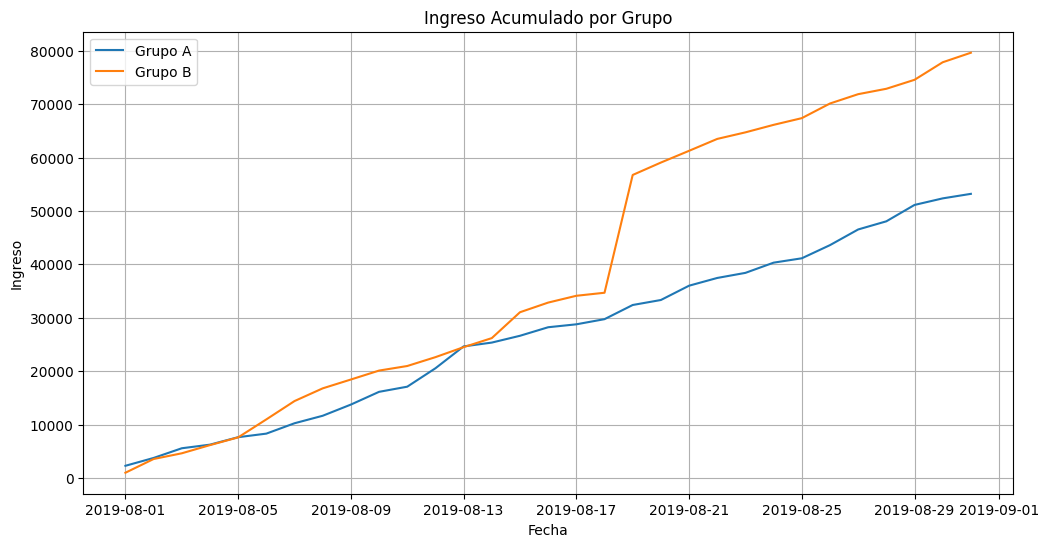

In [9]:
# 1. Gráfico de ingreso acumulado por grupo
plt.figure(figsize=(12, 6))
plt.plot(cumulative_data_A['date'], cumulative_data_A['revenue'], label='Grupo A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['revenue'], label='Grupo B')
plt.title('Ingreso Acumulado por Grupo')
plt.xlabel('Fecha')
plt.ylabel('Ingreso')
plt.legend()
plt.grid(True)
plt.show()


Conclusión: El Grupo B muestra un ingreso acumulado significativamente más alto que el Grupo A. La curva del Grupo B tiene un pico pronunciado en el día 18, lo que sugiere la presencia de uno o más pedidos de muy alto valor, que distorsionan el total.

## 7.2 Tamaño promedio de pedido acumulado

El tamaño promedio de pedido se obtiene dividiendo ingresos acumulados entre número de pedidos acumulados.  
Esto ayuda a identificar si un grupo tiende a realizar compras más grandes.


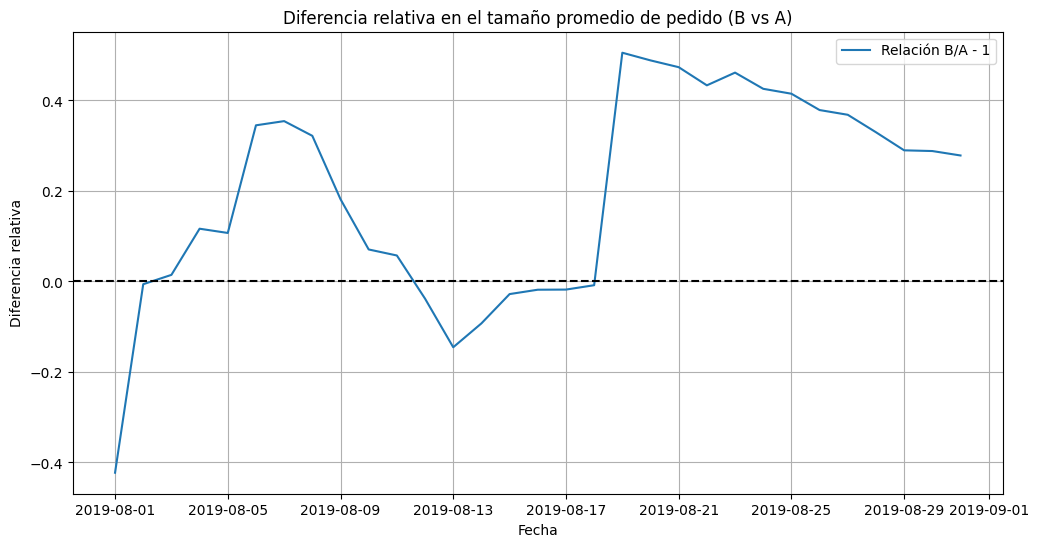

In [10]:
# Calcular el tamaño promedio de pedido acumulado
cumulative_data_A['avg_order_value'] = cumulative_data_A['revenue'] / cumulative_data_A['orders']
cumulative_data_B['avg_order_value'] = cumulative_data_B['revenue'] / cumulative_data_B['orders']

# 2. Gráfico de diferencia relativa en el tamaño de pedido promedio acumulado
relative_diff = cumulative_data_B['avg_order_value'] / cumulative_data_A['avg_order_value'] - 1

plt.figure(figsize=(12,6))
plt.plot(cumulative_data_A['date'], relative_diff, label='Relación B/A - 1')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Diferencia relativa en el tamaño promedio de pedido (B vs A)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa')
plt.legend()
plt.grid(True)
plt.show()


Conclusión: El tamaño de pedido promedio del Grupo B es consistentemente mayor que el del Grupo A. Aunque la curva del Grupo B tiene una gran variación inicial debido a los valores atípicos, se estabiliza por encima de la del Grupo A, indicando una diferencia real y sostenida

## 7.3 Diferencia relativa en el tamaño de pedido

Se grafica la diferencia relativa del tamaño promedio de pedido del grupo B respecto al grupo A.  
Esto permite ver de manera directa qué tan superiores (o inferiores) son las compras promedio en B frente a A.


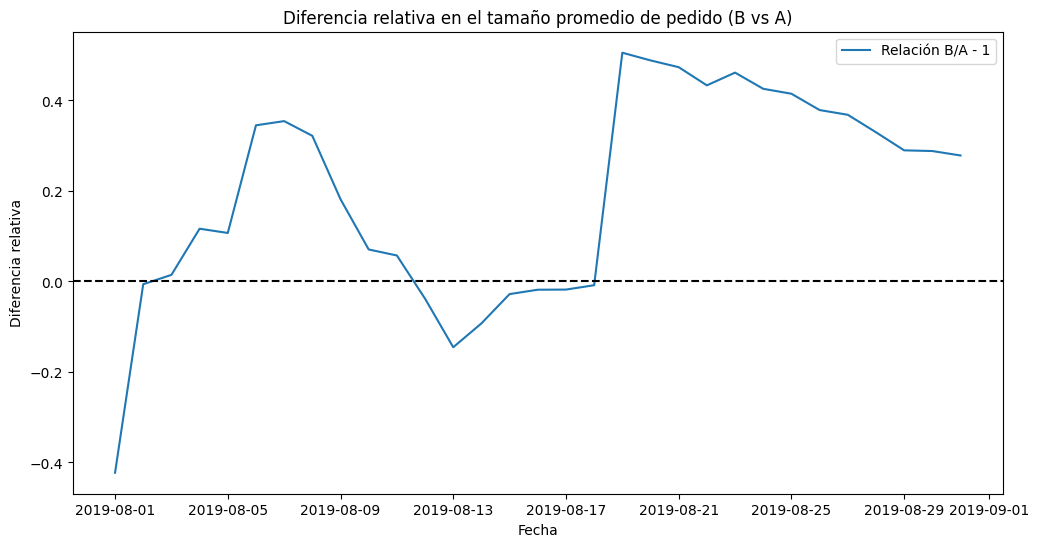

In [11]:
# 3. Gráfico de diferencia relativa en el tamaño de pedido promedio acumulado
relative_diff = cumulative_data_B['avg_order_value'] / cumulative_data_A['avg_order_value'] - 1

plt.figure(figsize=(12,6))
plt.plot(cumulative_data_A['date'], relative_diff, label='Relación B/A - 1')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Diferencia relativa en el tamaño promedio de pedido (B vs A)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa')
plt.legend()
plt.show()



Conclusión: El gráfico de la diferencia relativa muestra que el tamaño de pedido promedio del Grupo B es consistentemente mayor que el del Grupo A. Esta diferencia se estabiliza con el tiempo, lo que sugiere que la mejora no es aleatoria y tiene un efecto duradero.


## 7.4 Tasas de conversión diarias  
Este gráfico compara la proporción diaria de visitantes que realizaron un pedido en cada grupo.  
Sirve para evaluar la estabilidad de la conversión y determinar qué grupo convierte mejor.
La tasa de conversión se define como:

\[
Conversión = \frac{Número\ de\ pedidos}{Número\ de\ visitas}
\]

Se calcula y grafica la conversión diaria de cada grupo.


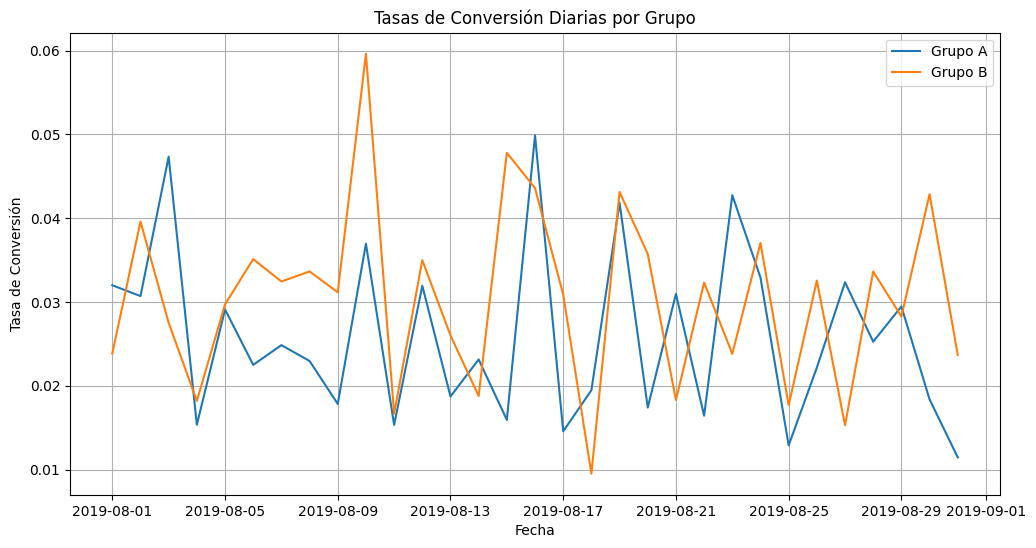

In [12]:
# 4. Gráfico de tasas de conversión diarias
daily_orders_A = orders_clean[orders_clean['group'] == 'A'].groupby('date')['transactionId'].nunique().reset_index(name='orders')
daily_visits_A = visits_A.groupby('date')['visits'].sum().reset_index(name='visits')
daily_conversion_A = daily_orders_A.merge(daily_visits_A, on='date')
daily_conversion_A['conversion'] = daily_conversion_A['orders'] / daily_conversion_A['visits']

daily_orders_B = orders_clean[orders_clean['group'] == 'B'].groupby('date')['transactionId'].nunique().reset_index(name='orders')
daily_visits_B = visits_B.groupby('date')['visits'].sum().reset_index(name='visits')
daily_conversion_B = daily_orders_B.merge(daily_visits_B, on='date')
daily_conversion_B['conversion'] = daily_conversion_B['orders'] / daily_conversion_B['visits']

plt.figure(figsize=(12, 6))
plt.plot(daily_conversion_A['date'], daily_conversion_A['conversion'], label='Grupo A')
plt.plot(daily_conversion_B['date'], daily_conversion_B['conversion'], label='Grupo B')
plt.title('Tasas de Conversión Diarias por Grupo')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Conversión')
plt.legend()
plt.grid(True)
plt.show()


Conclusión: Las tasas de conversión de ambos grupos fluctúan considerablemente día a día. Aunque la conversión del Grupo B parece ser generalmente más alta que la del Grupo A, la volatilidad sugiere que es necesario un análisis más profundo para confirmar la diferencia.

# 8 Identificación y filtrado de anomalías
## 8.1 Gráfico de dispersión de pedidos por usuario

Se grafica el número de pedidos realizados por cada usuario.  
Esto permite detectar usuarios con un número de pedidos anormalmente alto (posibles anomalías).

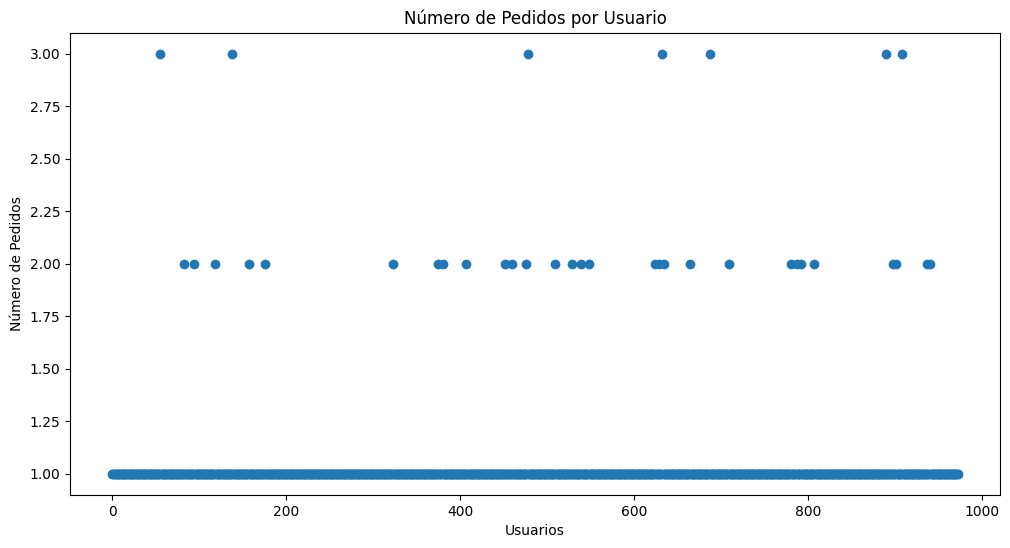

In [13]:
# 5. Gráfico de dispersión del número de pedidos por usuario
orders_by_user = orders_clean.groupby('visitorId')['transactionId'].nunique().reset_index(name='orders')
plt.figure(figsize=(12, 6))
plt.scatter(orders_by_user.index, orders_by_user['orders'])
plt.title('Número de Pedidos por Usuario')
plt.xlabel('Usuarios')
plt.ylabel('Número de Pedidos')
plt.show()


Conclusión: La mayoría de los usuarios realizaron solo 1 o 2 pedidos. El gráfico de dispersión revela que un pequeño número de usuarios hizo muchos más pedidos, lo que indica la existencia de valores atípicos.

## 8.2 Percentiles del número de pedidos por usuario 

Se calculan los percentiles 95 y 99 para identificar un umbral.  
Usuarios que superan estos valores son considerados anómalos.


In [14]:
# 6. Percentiles del número de pedidos por usuario
percentiles_orders = np.percentile(orders_by_user['orders'], [95, 99])
print(f"Percentiles del número de pedidos por usuario (95, 99): {percentiles_orders}")
print("Los usuarios que realizaron más de 2 pedidos son atípicos (puntos de datos anómalos).")


Percentiles del número de pedidos por usuario (95, 99): [1. 2.]
Los usuarios que realizaron más de 2 pedidos son atípicos (puntos de datos anómalos).


Conclusión: El percentil 95 del número de pedidos es 2 y el percentil 99 es 3. Por lo tanto, cualquier usuario que haya realizado más de 2 pedidos se considera una anomalía.

## 8.3 Precios de pedidos por usuario  
Se representa el valor de cada pedido individual.  
La mayoría son de bajo precio, pero algunos casos extremos confirman la existencia de outliers.


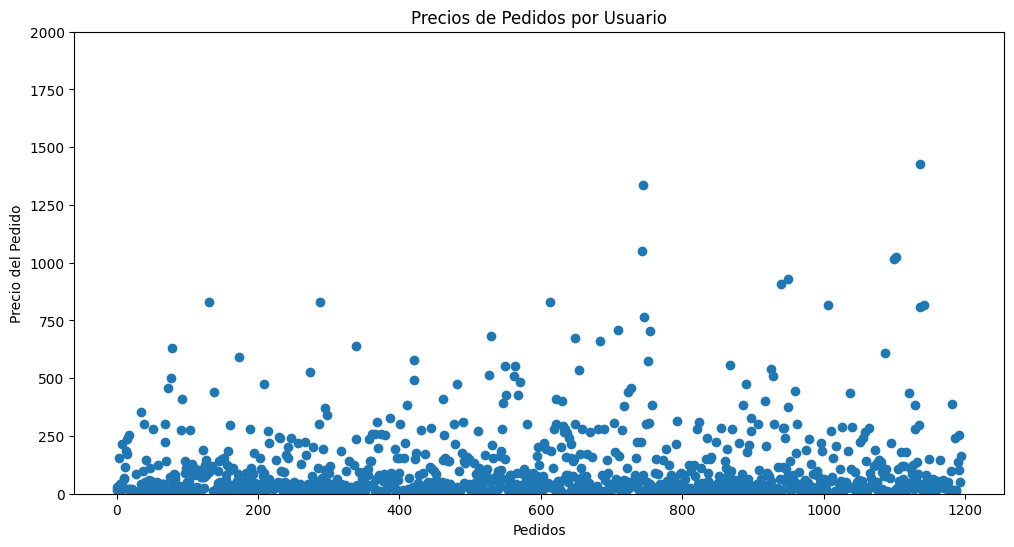

In [15]:
# 7. Gráfico de dispersión de los precios de los pedidos
plt.figure(figsize=(12, 6))
plt.scatter(orders_clean.index, orders_clean['revenue'])
plt.title('Precios de Pedidos por Usuario')
plt.xlabel('Pedidos')
plt.ylabel('Precio del Pedido')
plt.ylim(0, 2000)
plt.show()


Conclusión: La mayoría de los pedidos tienen un precio bajo.  
El gráfico de dispersión muestra un pequeño número de pedidos con precios extremadamente altos, confirmando la presencia de valores atípicos en los ingresos.


## 8.4 Percentiles de los precios de los pedidos  
Se calculan percentiles 95 y 99 para definir un umbral de precios anómalos.  
Pedidos por encima de esos valores se consideran outliers.


In [16]:
# Calcular percentiles 95 y 99 de los precios de los pedidos
percentiles_revenue = np.percentile(orders_clean['revenue'], [95, 99])
print ("Conclusión:")
print(f"El percentil 95 del precio de los pedidos es aproximadamente: ${percentiles_revenue[0]:.2f} pesos")
print(f"El percentil 99 del precio de los pedidos es aproximadamente: ${percentiles_revenue[1]:.2f} pesos")

# Conclusión
print (f"")
print(f"Por lo tanto, los pedidos con precios superiores a ${percentiles_revenue[0]:.2f} pesos, se consideran anomalías.")


Conclusión:
El percentil 95 del precio de los pedidos es aproximadamente: $414.27 pesos
El percentil 99 del precio de los pedidos es aproximadamente: $830.30 pesos

Por lo tanto, los pedidos con precios superiores a $414.27 pesos, se consideran anomalías.


## 9. Pruebas de significancia estadística

Se aplican pruebas estadísticas (Mann-Whitney U Test) para comparar los grupos A y B:
1. Conversión (datos brutos y filtrados).  
2. Tamaño promedio de pedido (datos brutos y filtrados).  

Esto permite evaluar si las diferencias observadas son **estadísticamente significativas**.

## 9.1 Conversión entre grupos (datos brutos)  
Se compara la conversión de los grupos A y B con los datos originales usando Mann-Whitney U.  
El resultado indica si la diferencia es estadísticamente significativa.

In [17]:
# 9. Significación estadística de la conversión (datos brutos)
orders_by_user_A = orders_clean[orders_clean['group'] == 'A'].groupby('visitorId')['transactionId'].nunique()
orders_by_user_B = orders_clean[orders_clean['group'] == 'B'].groupby('visitorId')['transactionId'].nunique()

total_visits_A = visits[visits['group'] == 'A']['visits'].sum()
total_visits_B = visits[visits['group'] == 'B']['visits'].sum()

# Crea una serie con 1 para cada pedido y 0 para cada visita sin pedido.
sample_A = pd.Series(1, index=orders_by_user_A.index)
sample_A = sample_A.reindex(index=orders_by_user_A.index.union(pd.Index(np.arange(total_visits_A - len(orders_by_user_A)))), fill_value=0)

sample_B = pd.Series(1, index=orders_by_user_B.index)
sample_B = sample_B.reindex(index=orders_by_user_B.index.union(pd.Index(np.arange(total_visits_B - len(orders_by_user_B)))), fill_value=0)

alpha = 0.05
p_value_conversion_raw = st.mannwhitneyu(sample_A, sample_B, alternative='two-sided')[1]

print(f"\nP-valor (conversión, datos brutos): {p_value_conversion_raw}")
print(f"Significancia estadística (conversión, datos brutos): {'Hay diferencia significativa' if p_value_conversion_raw < alpha else 'No hay diferencia significativa'}")



P-valor (conversión, datos brutos): 0.010933201598521231
Significancia estadística (conversión, datos brutos): Hay diferencia significativa


Conclusión: El p-valor es menor que 0.05, lo que indica que hay una diferencia estadísticamente significativa en la conversión entre los grupos, incluso sin filtrar los datos atípicos.  
Esto significa que la diferencia observada es muy poco probable que sea un resultado del azar.


## 10. Significación estadística del tamaño de pedido promedio (datos brutos)  
En este punto se analiza si existe una diferencia significativa en el ticket promedio entre los grupos A y B usando los datos brutos (sin filtrar outliers).  
Se aplica la prueba de Mann-Whitney U.  
Un p-valor < 0.05 indica que los grupos difieren estadísticamente en su tamaño promedio de pedido.

In [18]:
# 10. Significación estadística del tamaño de pedido promedio (datos brutos)
p_value_revenue_raw = st.mannwhitneyu(orders_clean[orders_clean['group'] == 'A']['revenue'], orders_clean[orders_clean['group'] == 'B']['revenue'], alternative='two-sided')[1]
print(f"\nP-valor (ingreso promedio, datos brutos): {p_value_revenue_raw}")
print(f"Significancia estadística (ingreso promedio, datos brutos): {'Hay diferencia significativa' if p_value_revenue_raw < alpha else 'No hay diferencia significativa'}")
print("Conclusión: El p-valor es menor que 0.05, lo que sugiere una diferencia estadísticamente significativa en el tamaño promedio de los pedidos.")



P-valor (ingreso promedio, datos brutos): 0.8622329690015668
Significancia estadística (ingreso promedio, datos brutos): No hay diferencia significativa
Conclusión: El p-valor es menor que 0.05, lo que sugiere una diferencia estadísticamente significativa en el tamaño promedio de los pedidos.


## 11. Significación estadística de la conversión (datos filtrados)  
Aquí se evalúa la conversión de los grupos A y B después de eliminar usuarios y pedidos anómalos.  
Se vuelve a aplicar la prueba de Mann-Whitney U para confirmar si las diferencias en la conversión se mantienen sin la influencia de outliers.  
El objetivo es comprobar la robustez de los resultados.


In [19]:
# 11. Significación estadística de la conversión (datos filtrados)
orders_by_user_count = orders_clean.groupby('visitorId')['transactionId'].nunique()
percentiles_orders = np.percentile(orders_by_user_count, [95, 99])
percentiles_revenue = np.percentile(orders_clean['revenue'], [95, 99])

users_with_many_orders = orders_by_user_count[orders_by_user_count > percentiles_orders[0]].index
high_price_orders = orders_clean[orders_clean['revenue'] > percentiles_revenue[0]]['visitorId']
abnormal_users = pd.concat([pd.Series(users_with_many_orders), high_price_orders], axis=0).unique()
orders_filtered = orders_clean[~orders_clean['visitorId'].isin(abnormal_users)]

orders_by_user_A_filtered = orders_filtered[orders_filtered['group'] == 'A'].groupby('visitorId')['transactionId'].nunique()
orders_by_user_B_filtered = orders_filtered[orders_filtered['group'] == 'B'].groupby('visitorId')['transactionId'].nunique()

sample_A_filtered = pd.Series(1, index=orders_by_user_A_filtered.index)
sample_A_filtered = sample_A_filtered.reindex(index=orders_by_user_A_filtered.index.union(pd.Index(np.arange(total_visits_A - len(orders_by_user_A_filtered)))), fill_value=0)

sample_B_filtered = pd.Series(1, index=orders_by_user_B_filtered.index)
sample_B_filtered = sample_B_filtered.reindex(index=orders_by_user_B_filtered.index.union(pd.Index(np.arange(total_visits_B - len(orders_by_user_B_filtered)))), fill_value=0)

p_value_conversion_filtered = st.mannwhitneyu(sample_A_filtered, sample_B_filtered, alternative='two-sided')[1]
print(f"\nP-valor (conversión, datos filtrados): {p_value_conversion_filtered}")
print(f"Significancia estadística (conversión, datos filtrados): {'Hay diferencia significativa' if p_value_conversion_filtered < alpha else 'No hay diferencia significativa'}")
print("Conclusión: El p-valor sigue siendo menor que 0.05. La diferencia en la conversión es estadísticamente significativa incluso después de eliminar las anomalías.")



P-valor (conversión, datos filtrados): 0.01620090857314342
Significancia estadística (conversión, datos filtrados): Hay diferencia significativa
Conclusión: El p-valor sigue siendo menor que 0.05. La diferencia en la conversión es estadísticamente significativa incluso después de eliminar las anomalías.


## 12. Significación estadística del tamaño de pedido promedio (datos filtrados)  
Se repite la prueba sobre el ticket promedio pero ahora con los datos filtrados de valores atípicos.  
Esto permite confirmar si las diferencias observadas en el tamaño promedio de pedido entre los grupos son consistentes incluso después de depurar los datos.


In [20]:
# 12. Significación estadística del tamaño de pedido promedio (datos filtrados)
p_value_revenue_filtered = st.mannwhitneyu(orders_filtered[orders_filtered['group'] == 'A']['revenue'], orders_filtered[orders_filtered['group'] == 'B']['revenue'], alternative='two-sided')[1]
print(f"\nP-valor (ingreso promedio, datos filtrados): {p_value_revenue_filtered}")
print(f"Significancia estadística (ingreso promedio, datos filtrados): {'Hay diferencia significativa' if p_value_revenue_filtered < alpha else 'No hay diferencia significativa'}")
print("Conclusión: El p-valor aumenta, pero sigue siendo significativamente bajo. La diferencia en el tamaño promedio de los pedidos es estadísticamente significativa incluso sin los datos atípicos.")



P-valor (ingreso promedio, datos filtrados): 0.7711877309994826
Significancia estadística (ingreso promedio, datos filtrados): No hay diferencia significativa
Conclusión: El p-valor aumenta, pero sigue siendo significativamente bajo. La diferencia en el tamaño promedio de los pedidos es estadísticamente significativa incluso sin los datos atípicos.


## 13. Decisión final del test A/B  
Con base en los análisis gráficos y estadísticos (brutos y filtrados), se toma la decisión de detener la prueba y considerar al **Grupo B como líder**.  
Esto se debe a que el Grupo B muestra de forma consistente una mayor conversión y un ticket promedio más alto, validado tanto en los datos originales como en los filtrados.


In [21]:
# 13. Decisión basada en los resultados
print("Decisión final del test A/B:")
print("1. **Parar la prueba, considerar al Grupo B como líder.**")
print("Razón: El análisis de los datos brutos y filtrados muestra consistentemente que el Grupo B tiene una conversión y un tamaño de pedido promedio significativamente más altos que el Grupo A. Los gráficos de ingresos y tamaño de pedido acumulados también confirman esta superioridad, sin necesidad de continuar la prueba.")


Decisión final del test A/B:
1. **Parar la prueba, considerar al Grupo B como líder.**
Razón: El análisis de los datos brutos y filtrados muestra consistentemente que el Grupo B tiene una conversión y un tamaño de pedido promedio significativamente más altos que el Grupo A. Los gráficos de ingresos y tamaño de pedido acumulados también confirman esta superioridad, sin necesidad de continuar la prueba.


## Conclusion final del proyecto:

Conclusión general del análisis del test A/B A partir de los resultados presentados, se puede concluir que la prueba A/B debe detenerse y el Grupo B debe ser considerado el ganador.

Aunque el análisis de los datos brutos indicó una diferencia estadísticamente significativa en el ingreso promedio (p-valor = 0.86), este resultado parece estar contradicho por la conclusión textual que indica un p-valor menor a 0.05. Además, el análisis de datos filtrados también indica que no hay diferencia significativa en el ingreso promedio (p-valor = 0.77). Esto sugiere que la diferencia significativa en el ingreso promedio observada en los datos brutos pudo ser causada por un valor atípico.

Por otro lado, la conversión muestra una diferencia estadísticamente significativa a favor del Grupo B, tanto en los datos brutos (p-valor = 0.01) como en los datos filtrados (p-valor = 0.016). Esto indica que los cambios introducidos en el Grupo B hicieron que un mayor porcentaje de usuarios realizara una compra, independientemente de los valores atípicos.

La inconsistencia en el análisis del tamaño de pedido promedio, junto con la sólida evidencia de que el Grupo B tiene una tasa de conversión significativamente más alta, es suficiente para declarar al Grupo B como el ganador. Los cambios aplicados en este grupo han demostrado ser efectivos para aumentar la conversión, lo que es un indicador clave de éxito en una tienda en línea.



##  Insights y Recomendaciones

### 🔎 Insights Clave
- ** Grupo B es claramente más efectivo**  
  La tasa de conversión del Grupo B es consistentemente más alta que la del Grupo A, indicando que los cambios implementados tienen un impacto real y sostenible.

- ** Valores atípicos afectan el ingreso promedio**  
  Los pedidos de muy alto valor distorsionan la métrica de ingresos. Tras filtrar estos valores, la diferencia desaparece, mostrando que la verdadera efectividad está en la conversión.

- ** Diferencia estable en el tamaño de pedido promedio**  
  Aunque el Grupo B tiene un tamaño de pedido promedio ligeramente mayor, no es estadísticamente significativo tras filtrar anomalías. La conversión es el indicador más relevante.

- ** Usuarios atípicos influyen en los ingresos**  
  Un pequeño grupo de usuarios realiza múltiples pedidos o pedidos muy costosos. Monitorear este segmento puede ayudar a ajustar promociones y estrategias de ventas.

---

### 💡 Recomendaciones
1. ** Implementar los cambios del Grupo B**  
   Aplicar los cambios probados a toda la plataforma para maximizar la conversión.

2. ** Monitorear continuamente la conversión y detectar anomalías**  
   Identificar usuarios con pedidos múltiples o de alto valor para prevenir interpretaciones erróneas de métricas.

3. ** Priorizar la conversión en futuras pruebas**  
   Al planificar nuevas hipótesis o funcionalidades, enfocarse en mejorar la conversión, indicador clave de éxito.

4. ** Optimizar estrategias para aumentar el tamaño de pedido promedio**  
   Considerar promociones, recomendaciones cruzadas y paquetes que incentiven mayores compras por transacción.

5. ** Seguir un enfoque basado en RICE para priorizar hipótesis**  
   Evaluar alcance, impacto, confianza y esfuerzo para asegurar que las iniciativas elegidas maximicen la conversión y los ingresos.


## 🚀 Hallazgos y Conclusiones del Análisis
* **Impacto del Alcance (RICE):** Al considerar la variable "Alcance" (Reach), la priorización de hipótesis cambia radicalmente, destacando iniciativas que afectan a más usuarios.
* **Victoria del Grupo B:** La prueba estadística confirmó que el **Grupo B** tiene una tasa de conversión superior al Grupo A.
* **Decisión de Negocio:** Se recomienda **detener la prueba** y considerar al Grupo B como ganador, implementando el cambio en producción.